<a href="https://colab.research.google.com/github/Jungro-Lee/Jungro-Lee/blob/master/PS_predictions_Organ_Only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchvision as tv
import torch.nn as nn
from torch.nn import functional as F
import time
from PIL import Image
import PIL
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from torchsummary import summary as model_summary
import glob
import nibabel as nib
import skimage
import sklearn
from sklearn import model_selection
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceFocalLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
import tempfile
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.transforms import (
    Compose,
    EnsureChannelFirstd,
    LoadImage,
    LoadImaged,
    Orientationd,
    Rand3DElasticd,
    RandAffined,
    Spacingd,
    Resized,
    NormalizeIntensityd,
    ToTensord,
    AsDiscrete,
)
from monai.config import print_config
from typing import Optional

from tqdm import tqdm
# from tqdm.notebook import tqdm

print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')
print(f'torch.cuda.get_device_name(0): {torch.cuda.get_device_name(0)}')
print(f'torch.version.cuda: {torch.version.cuda}')
print(f'torch.cuda.device_count(): {torch.cuda.device_count()}')
print()
monai.config.print_config()

torch.cuda.is_available(): True
torch.cuda.get_device_name(0): Tesla T4
torch.version.cuda: 11.6
torch.cuda.device_count(): 1

MONAI version: 1.1.0
Numpy version: 1.22.4
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.9/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 3.0.2
scikit-image version: 0.19.3
Pillow version: 8.4.0
Tensorboard version: 2.11.2
gdown version: 4.6.4
TorchVision version: 0.14.1+cu116
tqdm version: 4.65.0
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.4.4
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.2.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## 구성
1. 데이터 불러오기
2. 데이터 체크(형태, 구조, 자료형 확인)
3. 데이터 전처리
    - minmax
    - resize 등
4. 2번 다시
5. 시각화

In [19]:
### HYPER PARAMETER ###

RANDOM_SEED = 831
IMAGE_SIZE = (128, 128, 128)
BATCH_SIZE = 2
NUM_CLASS = 2
EPOCHS = 50
test_ratio, val_ratio = 0.1, 0.2

MODEL_SAVE = True
if MODEL_SAVE:
    model_dir1 = r"C:\Users\jungr\OneDrive\바탕 화면\data"
    model_dir2 = 'Segmentation(3D)-UNETR(bg)'
    MODEL_SAVE_PATH = os.path.join(model_dir1, model_dir2)
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'
print(DEVICE)
MODEL_SAVE_PATH

cuda


'C:\\Users\\jungr\\OneDrive\\바탕 화면\\data/Segmentation(3D)-UNETR(bg)'

0. 데이터 준비
- 데이터가 있으면 `data_dir`를 자신의 경로에 맞게 수정해주세요.
- 데이터가 없으면 `USE_MY_DATA` 를 `False`로 두고 다운로드 받으면 됩니다.
- The dataset comes from http://medicaldecathlon.com/.

In [5]:
USE_MY_DATA = False

if not USE_MY_DATA:
    directory = os.environ.get("MONAI_DATA_DIRECTORY")
    root_dir = tempfile.mkdtemp() if directory is None else directory
    print(f"root dir is: {root_dir}")
    
    resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
    md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

    compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
    data_dir = os.path.join(root_dir, "Task09_Spleen")
    if not os.path.exists(data_dir):
        download_and_extract(resource, compressed_file, root_dir, md5)

else:
    data_dir = r"C:\Users\jungr\OneDrive\바탕 화면\data\spleen_10.nii.gz"

root dir is: /tmp/tmp041i02wd


Task09_Spleen.tar: 1.50GB [01:36, 16.7MB/s]                            

2023-03-29 10:35:24,258 - INFO - Downloaded: /tmp/tmp041i02wd/Task09_Spleen.tar


2023-03-29 10:35:27,264 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-03-29 10:35:27,266 - INFO - Writing into directory: /tmp/tmp041i02wd.


In [6]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]
train_data_dicts[0]

{'image': '/tmp/tmp041i02wd/Task09_Spleen/imagesTr/spleen_10.nii.gz',
 'label': '/tmp/tmp041i02wd/Task09_Spleen/labelsTr/spleen_10.nii.gz'}

In [7]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

TrainSet, TestSet = model_selection.train_test_split(data_dicts, test_size=test_ratio, random_state=RANDOM_SEED)
TrainSet, ValSet = model_selection.train_test_split(TrainSet, test_size=val_ratio, random_state=RANDOM_SEED)
print('TrainSet:', len(TrainSet), 'ValSet:', len(ValSet), 'TestSet:', len(TestSet))

TrainSet: 28 ValSet: 8 TestSet: 5


In [8]:
for i in range(3):
    sample_img = nib.load(TrainSet[i]['image']).get_fdata()
    sample_mask = nib.load(TrainSet[i]['label']).get_fdata()
    print(f"[sample {i+1}] {os.path.basename(TrainSet[i]['image'])} {os.path.basename(TrainSet[i]['label'])}")
    print(sample_img.shape, sample_img.dtype, np.min(sample_img), np.max(sample_img))
    print(sample_mask.shape, sample_mask.dtype, np.unique(sample_mask))

[sample 1] spleen_2.nii.gz spleen_2.nii.gz
(512, 512, 90) float64 -1024.0 3071.0
(512, 512, 90) float64 [0. 1.]
[sample 2] spleen_19.nii.gz spleen_19.nii.gz
(512, 512, 51) float64 -1024.0 1372.0
(512, 512, 51) float64 [0. 1.]
[sample 3] spleen_17.nii.gz spleen_17.nii.gz
(512, 512, 95) float64 -1024.0 1964.0
(512, 512, 95) float64 [0. 1.]


In [9]:
from monai.transforms.compose import Transform, MapTransform

class MinMax(MapTransform):
    def __init__(self, keys):
        super().__init__(keys)

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            d[key] -= np.min(d[key])
            d[key] /= np.max(d[key])
        return d

loader = LoadImaged(keys=("image",'label'), image_only=False)
ensure_channel_first = EnsureChannelFirstd(keys=["image",'label'])
orientation = Orientationd(keys=["image",'label'], axcodes="RAS")
resize_img = Resized(keys=["image",], spatial_size=(IMAGE_SIZE), mode='trilinear')
resize_mask = Resized(keys=['label',], spatial_size=(IMAGE_SIZE), mode='nearest-exact')
# normalize = NormalizeIntensityd(keys=["image",])
minmax = MinMax(keys=['image',])

In [10]:
transforms = Compose([
    LoadImaged(keys=("image",'label'), image_only=False),
    EnsureChannelFirstd(keys=["image",'label']),
    Orientationd(keys=["image",'label'], axcodes="RAS"),
    Resized(keys=["image",], spatial_size=(IMAGE_SIZE), mode='trilinear'),
    Resized(keys=['label',], spatial_size=(IMAGE_SIZE), mode='nearest-exact'),
    # normalize = NormalizeIntensityd(keys=["image",])
    MinMax(keys=['image',]),
    ToTensord(keys=["image", "label"]),
    ])

SampleSet = transforms(TestSet[:3])

for i in range(3):
    sample_img = SampleSet[i]['image']
    sample_mask = SampleSet[i]['label']
    print(f"[sample {i+1}]")
    print(sample_img.shape, sample_img.dtype, torch.min(sample_img), torch.max(sample_img))
    print(sample_mask.shape, sample_mask.dtype, torch.unique(sample_mask))

[sample 1]
torch.Size([1, 128, 128, 128]) torch.float32 tensor(0.) tensor(1.)
torch.Size([1, 128, 128, 128]) torch.float32 tensor([0., 1.])
[sample 2]
torch.Size([1, 128, 128, 128]) torch.float32 tensor(0.) tensor(1.)
torch.Size([1, 128, 128, 128]) torch.float32 tensor([0., 1.])
[sample 3]
torch.Size([1, 128, 128, 128]) torch.float32 tensor(0.) tensor(1.)
torch.Size([1, 128, 128, 128]) torch.float32 tensor([0., 1.])


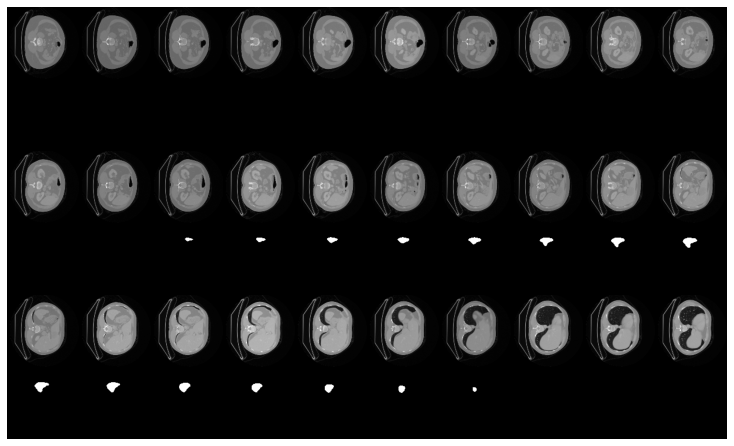

In [11]:
ncols, nrows = 10, 6
interval = int(IMAGE_SIZE[-1]//(ncols*nrows/2))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols,nrows))
cnt1, cnt2 = 0, 0
for i in range(nrows):
    for j in range(ncols):
        if i%2 == 0:
            axes[i,j].imshow(SampleSet[0]['image'][0,:,:,cnt1], cmap='gray')
            cnt1+=interval
        else:
            axes[i,j].imshow(SampleSet[0]['label'][0,:,:,cnt2], cmap='gray')
            cnt2+=interval
        axes[i,j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()  

In [12]:
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

train_ds = CacheDataset(
    data=TrainSet,
    transform=transforms,
    cache_num=4,
    cache_rate=1.0,
    num_workers=0)
val_ds = CacheDataset(
    data=ValSet, transform=transforms, cache_num=2, cache_rate=1.0, num_workers=0)
test_ds = CacheDataset(
    data=TestSet, transform=transforms, cache_num=2, cache_rate=1.0, num_workers=0)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(
    test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

Loading dataset: 100%|██████████| 2/2 [00:05<00:00,  2.90s/it]


In [13]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
from torch import Tensor

class SingleDeconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super().__init__()
        self.block = nn.ConvTranspose3d(in_planes, out_planes, kernel_size=2, stride=2, padding=0, output_padding=0)

    def forward(self, x):
        return self.block(x)


class SingleConv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super().__init__()
        self.block = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=1,
                               padding=((kernel_size - 1) // 2))

    def forward(self, x):
        return self.block(x)


class Conv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleConv3DBlock(in_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)
    
    
class Deconv3DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3):
        super().__init__()
        self.block = nn.Sequential(
            SingleDeconv3DBlock(in_planes, out_planes),
            SingleConv3DBlock(out_planes, out_planes, kernel_size),
            nn.BatchNorm3d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)    

class Embeddings(nn.Module):
    def __init__(self, input_shape, patch_size=16, embed_dim=768, dropout=0.):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = input_shape[-4]
        self.n_patches = int((input_shape[-1] * input_shape[-2] * input_shape[-3]) / (patch_size * patch_size * patch_size))
        self.embed_dim = embed_dim
        self.patch_embeddings = nn.Conv3d(in_channels=self.in_channels, out_channels=self.embed_dim,
                                          kernel_size=self.patch_size, stride=self.patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, self.n_patches, self.embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.patch_embeddings(x)
        x = rearrange(x, "b n h w d -> b (h w d) n")
        # batch, embed_dim, height/patch, width/patch, depth/patch
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy / scaling, dim=-1)
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int = 768, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=8, depth=12, dropout=0., extract_layers=[3,6,9,12]):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(embed_dim, MultiHeadAttention(embed_dim, num_heads, dropout)),
                PreNorm(embed_dim, FeedForwardBlock(embed_dim, expansion=4))
            ]))            
        self.extract_layers = extract_layers
        
    def forward(self, x):
        extract_layers = []
        
        for cnt, (attn, ff) in enumerate(self.layers):
            x = attn(x) + x
            x = ff(x) + x
            if cnt+1 in self.extract_layers:
                extract_layers.append(x)
            
        return extract_layers

class UNETR(nn.Module):
    def __init__(self, img_shape=(224, 224, 224), input_dim=3, output_dim=3, 
                 embed_dim=768, patch_size=16, num_heads=8, dropout=0.1, light_r=4):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.img_shape = img_shape
        self.patch_size = patch_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.num_layers = 12
        self.ext_layers = [3, 6, 9, 12]

        self.patch_dim = [int(x / patch_size) for x in img_shape]
        self.conv_channels = [int(i/light_r) for i in [32, 64, 128, 256, 512, 1024]]

        self.embedding = Embeddings((input_dim,*img_shape))
        
        # Transformer Encoder
        self.transformer = \
            TransformerBlock(
            )

        # U-Net Decoder
        self.decoder0 = \
            nn.Sequential(
                Conv3DBlock(input_dim, self.conv_channels[0], 3),
                Conv3DBlock(self.conv_channels[0], self.conv_channels[1], 3)
            )

        self.decoder3 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, self.conv_channels[2]),
                Deconv3DBlock(self.conv_channels[2], self.conv_channels[2]),
                Deconv3DBlock(self.conv_channels[2], self.conv_channels[2])
            )

        self.decoder6 = \
            nn.Sequential(
                Deconv3DBlock(embed_dim, self.conv_channels[3]),
                Deconv3DBlock(self.conv_channels[3], self.conv_channels[3]),
            )

        self.decoder9 = \
            Deconv3DBlock(embed_dim, self.conv_channels[4])

        self.decoder12_upsampler = \
            SingleDeconv3DBlock(embed_dim, self.conv_channels[4])

        self.decoder9_upsampler = \
            nn.Sequential(
                Conv3DBlock(self.conv_channels[5], self.conv_channels[3]),
                Conv3DBlock(self.conv_channels[3], self.conv_channels[3]),
                Conv3DBlock(self.conv_channels[3], self.conv_channels[3]),
                SingleDeconv3DBlock(self.conv_channels[3], self.conv_channels[3])
            )

        self.decoder6_upsampler = \
            nn.Sequential(
                Conv3DBlock(self.conv_channels[4], self.conv_channels[2]),
                Conv3DBlock(self.conv_channels[2], self.conv_channels[2]),
                SingleDeconv3DBlock(self.conv_channels[2], self.conv_channels[2])
            )

        self.decoder3_upsampler = \
            nn.Sequential(
                Conv3DBlock(self.conv_channels[3], self.conv_channels[1]),
                Conv3DBlock(self.conv_channels[1], self.conv_channels[1]),
                SingleDeconv3DBlock(self.conv_channels[1], self.conv_channels[1])
            )

        self.decoder0_header = \
            nn.Sequential(
                Conv3DBlock(self.conv_channels[2], self.conv_channels[1]),
                Conv3DBlock(self.conv_channels[1], self.conv_channels[1]),
                SingleConv3DBlock(self.conv_channels[1], output_dim, 1)
            )

    def forward(self, x):
        z0 = x
        x = self.embedding(x)
        z = self.transformer(x)
        z3, z6, z9, z12 = z
        z3 = z3.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z6 = z6.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z9 = z9.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)
        z12 = z12.transpose(-1, -2).view(-1, self.embed_dim, *self.patch_dim)

        z12 = self.decoder12_upsampler(z12)
        z9 = self.decoder9(z9)
        z9 = self.decoder9_upsampler(torch.cat([z9, z12], dim=1))
        z6 = self.decoder6(z6)
        z6 = self.decoder6_upsampler(torch.cat([z6, z9], dim=1))
        z3 = self.decoder3(z3)
        z3 = self.decoder3_upsampler(torch.cat([z3, z6], dim=1))
        z0 = self.decoder0(z0)
        output = self.decoder0_header(torch.cat([z0, z3], dim=1))
        return output

In [14]:
from monai.networks.nets import UNETR

model = UNETR(
    in_channels=1,
    out_channels=NUM_CLASS,
    img_size=IMAGE_SIZE,
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).float()
model = model.to(DEVICE)
# model_summary(model, (1,*IMAGE_SIZE), device=DEVICE.type)

In [15]:
from monai.losses import DiceCELoss, DiceLoss

torch.backends.cudnn.benchmark = True # ??

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

LossFuncion = monai.losses.DiceLoss(include_background=False, to_onehot_y=False, softmax=True)
MetricDice = monai.metrics.DiceMetric(include_background=False, reduction="mean")

In [16]:
def BinaryOutput(output, keepdim=True):
    shape = output.shape
    argmax_idx = torch.argmax(output, axis=1, keepdim=True)
    argmax_oh = F.one_hot(argmax_idx, num_classes=NUM_CLASS)
    if keepdim:
        argmax_oh = torch.squeeze(argmax_oh, dim=1)
    if len(shape) == 5:
        argmax_oh = argmax_oh.permute(0,4,1,2,3)
    elif len(shape) == 4:
        argmax_oh = argmax_oh.permute(0,3,1,2)
    
    return argmax_oh

In [17]:
from monai.losses.dice import DiceLoss, one_hot

def train(epoch, train_loader):
    model.train()
    mean_epoch_loss = 0
    mean_dice_score = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X EPOCHS) (loss=X.X) (dice score=%.5f)", 
        dynamic_ncols=True)
    
    for step, batch in enumerate(epoch_iterator):
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        y = torch.squeeze(y, dim=1)
        y = one_hot(y[:, None, ...], num_classes=NUM_CLASS)
        
        logit_map = model(x)
        loss = LossFuncion(logit_map, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        mean_epoch_loss += loss.item()
        
        bi_output = BinaryOutput(logit_map)
        MetricDice(bi_output, y)
        dice_score = MetricDice.aggregate().item()
        mean_dice_score += dice_score
        
        epoch_iterator.set_description(
            "Training (%d / %d EPOCHS) (loss=%2.5f) (dice score=%.5f)" 
            % (epoch, EPOCHS, loss, dice_score))
    
    mean_epoch_loss /= len(epoch_iterator)
    mean_dice_score /= len(epoch_iterator)
    
    return mean_epoch_loss, mean_dice_score



def evaluate(epoch, test_loader):
    model.eval() 
    mean_epoch_loss = 0
    mean_dice_score = 0
    epoch_iterator = tqdm(
        test_loader, desc="Evaluating (X / X EPOCHS) (loss=X.X) (dice score=%.5f)", 
        dynamic_ncols=True)
    
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator):
            x, y = (batch["image"].cuda(), batch["label"].cuda())
            y = torch.squeeze(y, dim=1)
            y = one_hot(y[:, None, ...], num_classes=NUM_CLASS)

            logit_map = model(x)
            loss = LossFuncion(logit_map, y)
            mean_epoch_loss += loss.item()

            bi_output = BinaryOutput(logit_map)
            MetricDice(bi_output, y)
            dice_score = MetricDice.aggregate().item()
            mean_dice_score += dice_score

            epoch_iterator.set_description(
                "Evaluating (%d / %d EPOCHS) (loss=%2.5f) (dice score=%.5f)" 
                % (epoch, EPOCHS, loss, dice_score))

    mean_epoch_loss /= len(epoch_iterator)
    mean_dice_score /= len(epoch_iterator)
    
    MetricDice.reset() # reset the status for next validation round
    
    return mean_epoch_loss, mean_dice_score    


In [20]:
losses = {'train':[], 'val':[]}
dice_scores = {'train':[], 'val':[]}
best_metric, best_epoch = 999, -1

for epoch in range(1, EPOCHS+1):
    train_loss, train_dice_score = train(epoch, train_loader)
    val_loss, val_dice_score = evaluate(epoch, val_loader)
    
    losses['train'].append(train_loss)
    losses['val'].append(val_loss)
    dice_scores['train'].append(train_dice_score)
    dice_scores['val'].append(val_dice_score)

    if losses['val'][-1] < best_metric:
        best_metric = losses['val'][-1]
        best_epoch = epoch
        print(f'Best record! [{epoch}] Test Loss: {val_loss:.6f}, Dice score: {val_dice_score:.6f}')
        if MODEL_SAVE:
            model_name = f'{best_epoch}_{best_metric}.pth'
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, model_name))
            print('saved model')


Training (1 / 50 EPOCHS) (loss=0.78148) (dice score=0.76133): 100%|██████████| 14/14 [00:58<00:00,  4.17s/it]
Evaluating (1 / 50 EPOCHS) (loss=0.68137) (dice score=0.73797): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


Best record! [1] Test Loss: 0.722088, Dice score: 0.743644
saved model


Training (2 / 50 EPOCHS) (loss=0.45445) (dice score=0.78654): 100%|██████████| 14/14 [00:58<00:00,  4.20s/it]
Evaluating (2 / 50 EPOCHS) (loss=0.64222) (dice score=0.74420): 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Best record! [2] Test Loss: 0.694872, Dice score: 0.755325
saved model


Training (3 / 50 EPOCHS) (loss=0.64837) (dice score=0.78579): 100%|██████████| 14/14 [00:58<00:00,  4.17s/it]
Evaluating (3 / 50 EPOCHS) (loss=0.64160) (dice score=0.73354): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Best record! [3] Test Loss: 0.694474, Dice score: 0.745548
saved model


Training (4 / 50 EPOCHS) (loss=0.84455) (dice score=0.79527): 100%|██████████| 14/14 [00:59<00:00,  4.27s/it]
Evaluating (4 / 50 EPOCHS) (loss=0.65426) (dice score=0.75078): 100%|██████████| 8/8 [00:08<00:00,  1.10s/it]
Training (5 / 50 EPOCHS) (loss=0.71088) (dice score=0.79993): 100%|██████████| 14/14 [00:59<00:00,  4.22s/it]
Evaluating (5 / 50 EPOCHS) (loss=0.61946) (dice score=0.75363): 100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Best record! [5] Test Loss: 0.675912, Dice score: 0.766210
saved model


Training (6 / 50 EPOCHS) (loss=0.63648) (dice score=0.81690): 100%|██████████| 14/14 [00:59<00:00,  4.23s/it]
Evaluating (6 / 50 EPOCHS) (loss=0.65721) (dice score=0.76052): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]
Training (7 / 50 EPOCHS) (loss=0.43368) (dice score=0.83042): 100%|██████████| 14/14 [00:59<00:00,  4.23s/it]
Evaluating (7 / 50 EPOCHS) (loss=0.56794) (dice score=0.77736): 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Best record! [7] Test Loss: 0.652932, Dice score: 0.790537
saved model


Training (8 / 50 EPOCHS) (loss=0.62917) (dice score=0.83087): 100%|██████████| 14/14 [01:00<00:00,  4.31s/it]
Evaluating (8 / 50 EPOCHS) (loss=0.58747) (dice score=0.78058): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]
Training (9 / 50 EPOCHS) (loss=0.72946) (dice score=0.84411): 100%|██████████| 14/14 [00:59<00:00,  4.22s/it]
Evaluating (9 / 50 EPOCHS) (loss=0.59066) (dice score=0.78892): 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


Best record! [9] Test Loss: 0.648188, Dice score: 0.805501
saved model


Training (10 / 50 EPOCHS) (loss=0.63321) (dice score=0.83499): 100%|██████████| 14/14 [00:59<00:00,  4.24s/it]
Evaluating (10 / 50 EPOCHS) (loss=0.61000) (dice score=0.78281): 100%|██████████| 8/8 [00:09<00:00,  1.15s/it]
Training (11 / 50 EPOCHS) (loss=0.59835) (dice score=0.84938): 100%|██████████| 14/14 [00:57<00:00,  4.13s/it]
Evaluating (11 / 50 EPOCHS) (loss=0.54567) (dice score=0.79335): 100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Best record! [11] Test Loss: 0.630644, Dice score: 0.808224
saved model


Training (12 / 50 EPOCHS) (loss=0.59081) (dice score=0.86182): 100%|██████████| 14/14 [00:58<00:00,  4.21s/it]
Evaluating (12 / 50 EPOCHS) (loss=0.55253) (dice score=0.80520): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Best record! [12] Test Loss: 0.623047, Dice score: 0.821997
saved model


Training (13 / 50 EPOCHS) (loss=0.32127) (dice score=0.87190): 100%|██████████| 14/14 [00:59<00:00,  4.24s/it]
Evaluating (13 / 50 EPOCHS) (loss=0.53646) (dice score=0.81533): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]
Training (14 / 50 EPOCHS) (loss=0.46039) (dice score=0.86705): 100%|██████████| 14/14 [00:58<00:00,  4.21s/it]
Evaluating (14 / 50 EPOCHS) (loss=0.49802) (dice score=0.81201): 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


Best record! [14] Test Loss: 0.600133, Dice score: 0.827734
saved model


Training (15 / 50 EPOCHS) (loss=0.45676) (dice score=0.86614): 100%|██████████| 14/14 [01:00<00:00,  4.32s/it]
Evaluating (15 / 50 EPOCHS) (loss=0.51707) (dice score=0.81312): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]
Training (16 / 50 EPOCHS) (loss=0.51771) (dice score=0.87276): 100%|██████████| 14/14 [00:59<00:00,  4.22s/it]
Evaluating (16 / 50 EPOCHS) (loss=0.51873) (dice score=0.81629): 100%|██████████| 8/8 [00:09<00:00,  1.14s/it]


Best record! [16] Test Loss: 0.597608, Dice score: 0.831281
saved model


Training (17 / 50 EPOCHS) (loss=0.52051) (dice score=0.86403): 100%|██████████| 14/14 [00:59<00:00,  4.27s/it]
Evaluating (17 / 50 EPOCHS) (loss=0.48438) (dice score=0.80715): 100%|██████████| 8/8 [00:08<00:00,  1.09s/it]
Training (18 / 50 EPOCHS) (loss=0.48278) (dice score=0.84628): 100%|██████████| 14/14 [00:59<00:00,  4.22s/it]
Evaluating (18 / 50 EPOCHS) (loss=0.48723) (dice score=0.78286): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]
Training (19 / 50 EPOCHS) (loss=0.37342) (dice score=0.84492): 100%|██████████| 14/14 [00:59<00:00,  4.23s/it]
Evaluating (19 / 50 EPOCHS) (loss=0.45234) (dice score=0.78516): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]
Training (20 / 50 EPOCHS) (loss=0.55188) (dice score=0.82373): 100%|██████████| 14/14 [00:58<00:00,  4.20s/it]
Evaluating (20 / 50 EPOCHS) (loss=0.44170) (dice score=0.77940): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Best record! [20] Test Loss: 0.552025, Dice score: 0.789536
saved model


Training (21 / 50 EPOCHS) (loss=0.47118) (dice score=0.84299): 100%|██████████| 14/14 [00:58<00:00,  4.21s/it]
Evaluating (21 / 50 EPOCHS) (loss=0.42802) (dice score=0.79259): 100%|██████████| 8/8 [00:08<00:00,  1.10s/it]
Training (22 / 50 EPOCHS) (loss=0.39635) (dice score=0.85147): 100%|██████████| 14/14 [00:58<00:00,  4.17s/it]
Evaluating (22 / 50 EPOCHS) (loss=0.42804) (dice score=0.80924): 100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Best record! [22] Test Loss: 0.545060, Dice score: 0.818109
saved model


Training (23 / 50 EPOCHS) (loss=0.50767) (dice score=0.87238): 100%|██████████| 14/14 [00:58<00:00,  4.19s/it]
Evaluating (23 / 50 EPOCHS) (loss=0.50600) (dice score=0.81125): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
Training (24 / 50 EPOCHS) (loss=0.58639) (dice score=0.89627): 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]
Evaluating (24 / 50 EPOCHS) (loss=0.44304) (dice score=0.83805): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Best record! [24] Test Loss: 0.540366, Dice score: 0.854184
saved model


Training (25 / 50 EPOCHS) (loss=0.53397) (dice score=0.89864): 100%|██████████| 14/14 [00:59<00:00,  4.23s/it]
Evaluating (25 / 50 EPOCHS) (loss=0.47538) (dice score=0.83714): 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
Training (26 / 50 EPOCHS) (loss=0.40164) (dice score=0.90517): 100%|██████████| 14/14 [00:59<00:00,  4.25s/it]
Evaluating (26 / 50 EPOCHS) (loss=0.42104) (dice score=0.84498): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
Training (27 / 50 EPOCHS) (loss=0.19858) (dice score=0.91161): 100%|██████████| 14/14 [00:58<00:00,  4.17s/it]
Evaluating (27 / 50 EPOCHS) (loss=0.41052) (dice score=0.84822): 100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Best record! [27] Test Loss: 0.538351, Dice score: 0.867255
saved model


Training (28 / 50 EPOCHS) (loss=0.28021) (dice score=0.91672): 100%|██████████| 14/14 [00:59<00:00,  4.23s/it]
Evaluating (28 / 50 EPOCHS) (loss=0.42552) (dice score=0.85837): 100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


Best record! [28] Test Loss: 0.532783, Dice score: 0.875783
saved model


Training (29 / 50 EPOCHS) (loss=0.38404) (dice score=0.92100): 100%|██████████| 14/14 [00:59<00:00,  4.24s/it]
Evaluating (29 / 50 EPOCHS) (loss=0.46159) (dice score=0.85207): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]
Training (30 / 50 EPOCHS) (loss=0.26206) (dice score=0.92541): 100%|██████████| 14/14 [00:59<00:00,  4.26s/it]
Evaluating (30 / 50 EPOCHS) (loss=0.39800) (dice score=0.86392): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]
Training (31 / 50 EPOCHS) (loss=0.32035) (dice score=0.92614): 100%|██████████| 14/14 [00:59<00:00,  4.25s/it]
Evaluating (31 / 50 EPOCHS) (loss=0.41781) (dice score=0.85988): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]
Training (32 / 50 EPOCHS) (loss=0.22316) (dice score=0.92403): 100%|██████████| 14/14 [00:59<00:00,  4.26s/it]
Evaluating (32 / 50 EPOCHS) (loss=0.35901) (dice score=0.86043): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Best record! [32] Test Loss: 0.506502, Dice score: 0.878889
saved model


Training (33 / 50 EPOCHS) (loss=0.34292) (dice score=0.92192): 100%|██████████| 14/14 [00:59<00:00,  4.21s/it]
Evaluating (33 / 50 EPOCHS) (loss=0.45246) (dice score=0.84610): 100%|██████████| 8/8 [00:09<00:00,  1.15s/it]
Training (34 / 50 EPOCHS) (loss=0.25282) (dice score=0.92428): 100%|██████████| 14/14 [00:58<00:00,  4.18s/it]
Evaluating (34 / 50 EPOCHS) (loss=0.39571) (dice score=0.85859): 100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


Best record! [34] Test Loss: 0.505847, Dice score: 0.877859
saved model


Training (35 / 50 EPOCHS) (loss=0.26006) (dice score=0.92100): 100%|██████████| 14/14 [00:59<00:00,  4.23s/it]
Evaluating (35 / 50 EPOCHS) (loss=0.38772) (dice score=0.85332): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]
Training (36 / 50 EPOCHS) (loss=0.22388) (dice score=0.92775): 100%|██████████| 14/14 [00:58<00:00,  4.20s/it]
Evaluating (36 / 50 EPOCHS) (loss=0.36260) (dice score=0.85503): 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
Training (37 / 50 EPOCHS) (loss=0.24003) (dice score=0.91435): 100%|██████████| 14/14 [00:58<00:00,  4.18s/it]
Evaluating (37 / 50 EPOCHS) (loss=0.40315) (dice score=0.84785): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Best record! [37] Test Loss: 0.499339, Dice score: 0.867775
saved model


Training (38 / 50 EPOCHS) (loss=0.20885) (dice score=0.92083): 100%|██████████| 14/14 [00:58<00:00,  4.21s/it]
Evaluating (38 / 50 EPOCHS) (loss=0.37111) (dice score=0.85098): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]
Training (39 / 50 EPOCHS) (loss=0.35943) (dice score=0.91972): 100%|██████████| 14/14 [00:58<00:00,  4.17s/it]
Evaluating (39 / 50 EPOCHS) (loss=0.40727) (dice score=0.84746): 100%|██████████| 8/8 [00:09<00:00,  1.14s/it]
Training (40 / 50 EPOCHS) (loss=0.25318) (dice score=0.91394): 100%|██████████| 14/14 [00:57<00:00,  4.08s/it]
Evaluating (40 / 50 EPOCHS) (loss=0.41842) (dice score=0.84832): 100%|██████████| 8/8 [00:09<00:00,  1.13s/it]
Training (41 / 50 EPOCHS) (loss=0.19308) (dice score=0.91988): 100%|██████████| 14/14 [00:57<00:00,  4.10s/it]
Evaluating (41 / 50 EPOCHS) (loss=0.37551) (dice score=0.84581): 100%|██████████| 8/8 [00:08<00:00,  1.11s/it]
Training (42 / 50 EPOCHS) (loss=0.21970) (dice score=0.92260): 100%|██████████| 14/14 [00:57<00:00,  4.07s/it]
E

Best record! [42] Test Loss: 0.468502, Dice score: 0.875986
saved model


Training (43 / 50 EPOCHS) (loss=0.23844) (dice score=0.92442): 100%|██████████| 14/14 [00:58<00:00,  4.21s/it]
Evaluating (43 / 50 EPOCHS) (loss=0.37328) (dice score=0.85638): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]
Training (44 / 50 EPOCHS) (loss=0.18403) (dice score=0.93167): 100%|██████████| 14/14 [00:58<00:00,  4.18s/it]
Evaluating (44 / 50 EPOCHS) (loss=0.38605) (dice score=0.85918): 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
Training (45 / 50 EPOCHS) (loss=0.21463) (dice score=0.91966): 100%|██████████| 14/14 [00:58<00:00,  4.18s/it]
Evaluating (45 / 50 EPOCHS) (loss=0.26745) (dice score=0.86368): 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


Best record! [45] Test Loss: 0.444249, Dice score: 0.878429
saved model


Training (46 / 50 EPOCHS) (loss=0.22030) (dice score=0.91793): 100%|██████████| 14/14 [00:59<00:00,  4.28s/it]
Evaluating (46 / 50 EPOCHS) (loss=0.50214) (dice score=0.83212): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]
Training (47 / 50 EPOCHS) (loss=0.24072) (dice score=0.91223): 100%|██████████| 14/14 [00:59<00:00,  4.22s/it]
Evaluating (47 / 50 EPOCHS) (loss=0.29898) (dice score=0.84740): 100%|██████████| 8/8 [00:09<00:00,  1.14s/it]
Training (48 / 50 EPOCHS) (loss=0.28525) (dice score=0.90427): 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]
Evaluating (48 / 50 EPOCHS) (loss=0.25405) (dice score=0.85072): 100%|██████████| 8/8 [00:09<00:00,  1.13s/it]


Best record! [48] Test Loss: 0.440656, Dice score: 0.864388
saved model


Training (49 / 50 EPOCHS) (loss=0.23397) (dice score=0.91422): 100%|██████████| 14/14 [00:58<00:00,  4.15s/it]
Evaluating (49 / 50 EPOCHS) (loss=0.33710) (dice score=0.84181): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]
Training (50 / 50 EPOCHS) (loss=0.13692) (dice score=0.92019): 100%|██████████| 14/14 [00:58<00:00,  4.17s/it]
Evaluating (50 / 50 EPOCHS) (loss=0.31884) (dice score=0.85751): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


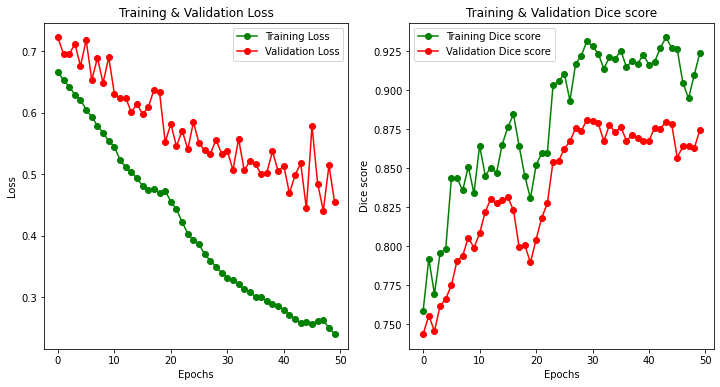

In [21]:
epochs = [i for i in range(len(losses['train']))]
train_loss = losses['train']
val_loss = losses['val']
train_dice = dice_scores['train']
val_dice = dice_scores['val']

fig , ax = plt.subplots(1,2)
fig.set_size_inches(12,6)

ax[0].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[0].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

ax[1].plot(epochs , train_dice , 'go-' , label = 'Training Dice score')
ax[1].plot(epochs , val_dice , 'ro-' , label = 'Validation Dice score')
ax[1].set_title('Training & Validation Dice score')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Dice score")

plt.show()

In [22]:
pred_dict = {'input':[], 'target':[], 'output':[]}

if MODEL_SAVE:
    model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, model_name)))

model.to('cpu')
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader):
        img, target = data["image"].cpu(), data["label"].cpu()

        output = model(img).detach().cpu()
        output = torch.argmax(output, dim=1)
        
        pred_dict['input'].append(img)
        pred_dict['target'].append(target)
        pred_dict['output'].append(output)
        
        if i > 10:
            break

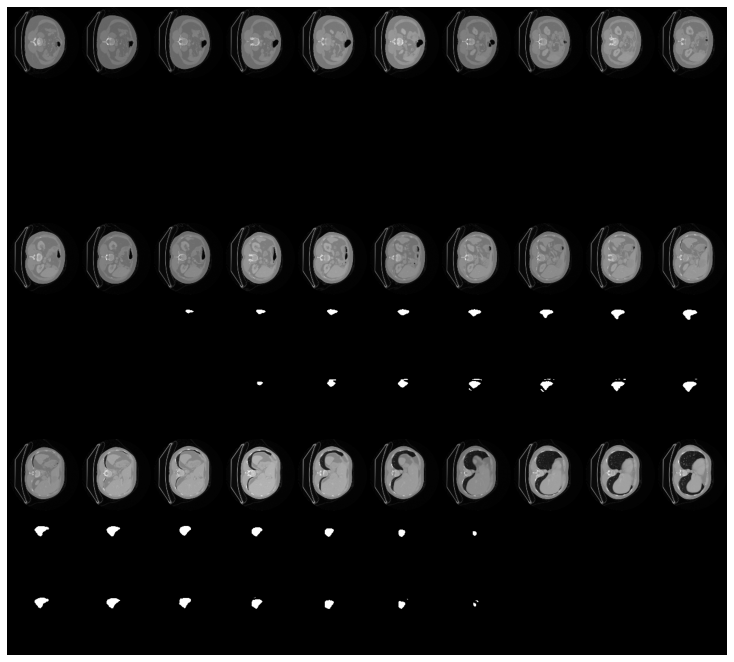

In [23]:
ncols, nrows = 10, 3*3
interval = int(IMAGE_SIZE[-1]//(ncols*nrows/3))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols,nrows))
cnt1, cnt2, cnt3 = 0, 0, 0
for i in range(nrows):
    for j in range(ncols):
        if i%3 == 0:
            axes[i,j].imshow(pred_dict['input'][0][0,0,:,:,cnt1], cmap='gray')
            cnt1+=interval
        elif i%3 == 1:
            axes[i,j].imshow(pred_dict['target'][0][0,0,:,:,cnt2], cmap='gray')
            cnt2+=interval
        else:
            axes[i,j].imshow(pred_dict['output'][0][0,:,:,cnt3], cmap='gray')
            cnt3+=interval
        axes[i,j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()  

In [25]:
plt.savefig(r"C:\Users\jungr\OneDrive\바탕 화면\data/PS_predictions_ORGAN_ONLY.png")

<Figure size 432x288 with 0 Axes>